# Build the inverse kinematic model based on collected data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import joblib
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Load the saved dataset in a_files
data = np.load("data_optitrack/data_MASS9000_actrange150_date2105_1.npz")

# List all arrays stored inside
print(data.files)
files = data.files

['actual_position_list', 'act_list', 'wanted_position_list']


In [3]:
for file in files:
    print(f"{file}: {data[file].shape}")

actual_position_list: (9000, 3, 3)
act_list: (9000, 3, 3)
wanted_position_list: (9000, 3, 3)


In [4]:
print("actual_position_list:") 
print(data["actual_position_list"][0:5])
print("wanted_position_list:")
print(data["wanted_position_list"][0:5])
print("act_list:")
print(data["act_list"][0:5])

actual_position_list:
[[[10304.  9778. 10495.]
  [10256.  9821. 12483.]
  [13961.  9861. 10197.]]

 [[10304.  9778. 10495.]
  [10256.  9821. 12483.]
  [13962.  9861. 10197.]]

 [[10275.  9880. 10495.]
  [10178.  9863. 12483.]
  [13944.  9971. 10197.]]

 [[10125.  9820. 10771.]
  [10024.  9823. 12679.]
  [13793.  9928. 10381.]]

 [[10124.  9736. 10810.]
  [10024.  9737. 12735.]
  [13794.  9842. 10442.]]]
wanted_position_list:
[[[10364.  9827. 10563.]
  [10261.  9824. 12527.]
  [14026.  9925. 10239.]]

 [[10286.  9946. 10522.]
  [10183.  9943. 12486.]
  [13948. 10044. 10198.]]

 [[10138.  9825. 10791.]
  [10035.  9822. 12755.]
  [13800.  9923. 10467.]]

 [[10154.  9739. 10861.]
  [10051.  9736. 12825.]
  [13816.  9837. 10537.]]

 [[10103.  9841. 10810.]
  [10000.  9838. 12774.]
  [13765.  9939. 10486.]]]
act_list:
[[[   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[ -78.  119.  -41.]
  [ -78.  119.  -41.]
  [ -78.  119.  -41.]]

 [[-226.   -2.  228.]
  [-226.   -2.  22

In [5]:
safe_position = data["actual_position_list"][0]
print("First actual_position_list = Safe baseline position:", data["actual_position_list"][0])

# Subtract all actual_position_list by the first element to get the relative position -> delta L
actual_position_list = data["actual_position_list"] - safe_position

# print("actual position list:",actual_position_list[0:10])

# delete the first element of the actual_position_list
actual_position_list = np.delete(actual_position_list, 0, axis=0)
print("actual position list:",actual_position_list[0:10])
print("actual position list shape:",actual_position_list.shape)

First actual_position_list = Safe baseline position: [[10304.  9778. 10495.]
 [10256.  9821. 12483.]
 [13961.  9861. 10197.]]
actual position list: [[[   0.    0.    0.]
  [   0.    0.    0.]
  [   1.    0.    0.]]

 [[ -29.  102.    0.]
  [ -78.   42.    0.]
  [ -17.  110.    0.]]

 [[-179.   42.  276.]
  [-232.    2.  196.]
  [-168.   67.  184.]]

 [[-180.  -42.  315.]
  [-232.  -84.  252.]
  [-167.  -19.  245.]]

 [[-215.    3.  309.]
  [-260.  -27.  252.]
  [-199.   13.  245.]]

 [[-332.   28.  387.]
  [-383.   -2.  311.]
  [-317.   13.  307.]]

 [[-158.  -64.  323.]
  [-223. -105.  307.]
  [-174.  -38.  305.]]

 [[ -15.  -64.  169.]
  [ -67. -105.  153.]
  [ -42.  -38.  145.]]

 [[  53.  -12.   20.]
  [   3.  -58.    5.]
  [  29.  -16.   -3.]]

 [[  33.  -12.   55.]
  [ -13.  -57.   38.]
  [  29.  -16.   22.]]]
actual position list shape: (8999, 3, 3)


In [6]:
# Position and rotation data
path = "optitrack_mass_data_full_bodies_data9000_actrange150_date2105_1.csv"
dt = pd.read_csv(path)
print(dt.shape)

# print the last 2 rows of the dataframe
print(dt.tail(5))

# delete the last row of the dataframe
dt = dt.drop(dt.index[-1])
print(dt.shape)

(9000, 25)
         Timestamp  SA-base-X  SA-base-Y  SA-base-Z  SA-base-Roll  \
8995  1.747857e+09  -0.343672   0.149910   0.026239      0.967996   
8996  1.747857e+09  -0.343671   0.149917   0.026230      0.971739   
8997  1.747857e+09  -0.343665   0.149931   0.026215      0.966993   
8998  1.747857e+09  -0.343636   0.149918   0.026211      0.975180   
8999  1.747857e+09  -0.343659   0.149912   0.026232      0.943057   

      SA-base-Pitch  SA-base-Yaw  SA-low-X  SA-low-Y  SA-low-Z  ...  \
8995      -0.204804     1.034005 -0.420955  0.335037 -0.026574  ...   
8996      -0.208236     1.029143 -0.420144  0.335406 -0.026750  ...   
8997      -0.199051     1.029640 -0.421343  0.334737 -0.028389  ...   
8998      -0.199377     1.021272 -0.422386  0.333893 -0.030319  ...   
8999      -0.207813     1.016038 -0.421377  0.334281 -0.030798  ...   

      SA-middle-Z  SA-middle-Roll  SA-middle-Pitch  SA-middle-Yaw   SA-up-X  \
8995    -0.014419       13.827633        -5.998618      75.834065 -0

In [7]:
# Extract the position (not the rotation) data of 3 sections (low, middle, up)
# SA-low-X, SA-low-Y, SA-low-Z
# SA-middle-X, SA-middle-Y, SA-middle-Z
# SA-up-X, SA-up-Y, SA-up-Z

pos_low = dt[["SA-low-X", "SA-low-Y", "SA-low-Z"]].values
pos_mid = dt[["SA-middle-X", "SA-middle-Y", "SA-middle-Z"]].values
pos_up = dt[["SA-up-X", "SA-up-Y", "SA-up-Z"]].values

# Extract the rotation data of 3 sections (low, middle, up)
# SA-low-Roll, SA-low-Pitch, SA-low-Yaw
# SA-middle-Roll, SA-middle-Pitch, SA-middle-Yaw
# SA-up-Roll, SA-up-Pitch, SA-up-Yaw

rot_low = dt[["SA-low-Roll", "SA-low-Pitch", "SA-low-Yaw"]].values
rot_mid = dt[["SA-middle-Roll", "SA-middle-Pitch", "SA-middle-Yaw"]].values
rot_up = dt[["SA-up-Roll", "SA-up-Pitch", "SA-up-Yaw"]].values

# Concatenate the position and rotation data
pos_data = np.concatenate((pos_low, pos_mid, pos_up), axis=1)
rot_data = np.concatenate((rot_low, rot_mid, rot_up), axis=1)

In [8]:
pos_up[0:5] 

array([[-0.34038705,  0.77840608, -0.01741984],
       [-0.32379043,  0.77728498, -0.02210428],
       [-0.3317562 ,  0.76822215, -0.1032236 ],
       [-0.3520484 ,  0.76652128, -0.11211121],
       [-0.34436703,  0.76605713, -0.1148265 ]])

In [9]:
print(pos_data.shape)
pos_data

(8999, 9)


array([[-0.34552962,  0.35931316, -0.00530792, ..., -0.34038705,
         0.77840608, -0.01741984],
       [-0.34286535,  0.35923934, -0.00560493, ..., -0.32379043,
         0.77728498, -0.02210428],
       [-0.34266335,  0.35876322, -0.01724807, ..., -0.3317562 ,
         0.76822215, -0.1032236 ],
       ...,
       [-0.42014381,  0.33540601, -0.02674985, ..., -0.78910023,
         0.44519326,  0.06198361],
       [-0.421343  ,  0.33473715, -0.02838919, ..., -0.78553098,
         0.43973413,  0.07603768],
       [-0.42238602,  0.33389288, -0.03031909, ..., -0.78916109,
         0.42835513,  0.07062013]], shape=(8999, 9))

### Goal
**Input:** Desired positions (only of end effector --> 3 values)

**Output:** Delta L (actuation list --> 9 values)

# Neural Network

## Inverse Kinematics

In [10]:
# For inverse kinematics training:
# Extract only the end effectors positions
X_ik = pos_data  # shape: (8999, 9)
print("X_ik shape:", X_ik.shape)

Y_ik = actual_position_list.reshape(8999, -1) # shape: (8999, 9)
print("Y_ik shape:", Y_ik.shape)

# Normalize
scaler_X_ik = MinMaxScaler()
scaler_Y_ik = MinMaxScaler()

X_ik_norm = scaler_X_ik.fit_transform(X_ik)  # Positions normalized explicitly
Y_ik_norm = scaler_Y_ik.fit_transform(Y_ik)  # Actuators normalized explicitly

# Split into train/test
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X_ik_norm, Y_ik_norm, test_size=0.2, random_state=42)

# After train_test_split (already split into 80% train, 20% test)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, test_size=0.1, random_state=42)

# X_train:  72%
# X_val:    8%
# X_test:   20%

# Convert to PyTorch tensors
X_ik_train = torch.tensor(X_train, dtype=torch.float32)
Y_ik_train = torch.tensor(Y_train, dtype=torch.float32)
X_ik_val = torch.tensor(X_val, dtype=torch.float32)
Y_ik_val = torch.tensor(Y_val, dtype=torch.float32)
X_ik_test = torch.tensor(X_test, dtype=torch.float32)
Y_ik_test = torch.tensor(Y_test, dtype=torch.float32)

X_ik shape: (8999, 9)
Y_ik shape: (8999, 9)


In [11]:
class InverseKinematicMLP(nn.Module):
    def __init__(self, input_size=9, output_size=9):
        super(InverseKinematicMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        return self.net(x)

model_ik = InverseKinematicMLP(input_size=9, output_size=9)

In [12]:
# Create DataLoader for inverse kinematics training
train_loader_ik = DataLoader(TensorDataset(X_ik_train, Y_ik_train), batch_size=64, shuffle=True)
val_loader_ik = DataLoader(TensorDataset(X_ik_val, Y_ik_val), batch_size=64, shuffle=False)

loss_fn_ik = nn.MSELoss()
optimizer_ik = torch.optim.Adam(model_ik.parameters(), lr=0.001)

In [12]:
from sklearn.metrics import root_mean_squared_error

num_epochs = 100
train_losses = []
val_losses = []

rmse_train_pos_epochs = []
rmse_val_pos_epochs = []

for epoch in range(num_epochs):
    model_ik.train()
    batch_train_losses = []

    all_preds_train = []
    all_labels_train = []

    for X_batch, Y_batch in train_loader_ik:
        optimizer_ik.zero_grad()
        Y_pred = model_ik(X_batch)
        loss = loss_fn_ik(Y_pred, Y_batch)
        loss.backward()
        optimizer_ik.step()
        batch_train_losses.append(loss.item())

        # Save predictions for metrics calculation
        all_preds_train.append(Y_pred.detach())
        all_labels_train.append(Y_batch)

    train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(train_loss)

    # Evaluate training set accuracy WITHOUT gradient computations
    model_ik.eval()

    # --- Validation ---
    batch_val_losses = []
    all_preds_val = []
    all_labels_val = []

    with torch.no_grad():
        for X_val_batch, Y_val_batch in val_loader_ik:
            Y_val_pred = model_ik(X_val_batch)
            val_loss = loss_fn_ik(Y_val_pred, Y_val_batch)
            batch_val_losses.append(val_loss.item())
            all_preds_val.append(Y_val_pred)
            all_labels_val.append(Y_val_batch)

    val_loss = sum(batch_val_losses) / len(batch_val_losses)
    val_losses.append(val_loss)

    all_preds_val = torch.cat(all_preds_val).cpu().numpy()
    all_labels_val = torch.cat(all_labels_val).cpu().numpy()

    all_preds_val = scaler_Y_ik.inverse_transform(all_preds_val)
    all_labels_val = scaler_Y_ik.inverse_transform(all_labels_val)

    val_pos_pred = all_preds_val[:, :9]
    val_pos_true = all_labels_val[:, :9]

    rmse_val_pos = root_mean_squared_error(val_pos_true, val_pos_pred)
    rmse_val_pos_epochs.append(rmse_val_pos)

    if epoch % 1 == 0:
        print(f"Epoch {epoch} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | ")


Epoch 0 | Train Loss: 0.085137 | Val Loss: 0.025452 | 
Epoch 1 | Train Loss: 0.023638 | Val Loss: 0.021973 | 
Epoch 2 | Train Loss: 0.021482 | Val Loss: 0.020107 | 
Epoch 3 | Train Loss: 0.019678 | Val Loss: 0.017610 | 
Epoch 4 | Train Loss: 0.016674 | Val Loss: 0.014462 | 
Epoch 5 | Train Loss: 0.013921 | Val Loss: 0.012109 | 
Epoch 6 | Train Loss: 0.011743 | Val Loss: 0.009791 | 
Epoch 7 | Train Loss: 0.009633 | Val Loss: 0.007909 | 
Epoch 8 | Train Loss: 0.007965 | Val Loss: 0.007181 | 
Epoch 9 | Train Loss: 0.006768 | Val Loss: 0.007241 | 
Epoch 10 | Train Loss: 0.006052 | Val Loss: 0.005586 | 
Epoch 11 | Train Loss: 0.005245 | Val Loss: 0.005172 | 
Epoch 12 | Train Loss: 0.004738 | Val Loss: 0.005198 | 
Epoch 13 | Train Loss: 0.004397 | Val Loss: 0.004684 | 
Epoch 14 | Train Loss: 0.004130 | Val Loss: 0.004071 | 
Epoch 15 | Train Loss: 0.003885 | Val Loss: 0.004097 | 
Epoch 16 | Train Loss: 0.003735 | Val Loss: 0.004067 | 
Epoch 17 | Train Loss: 0.003474 | Val Loss: 0.003505 | 
Ep

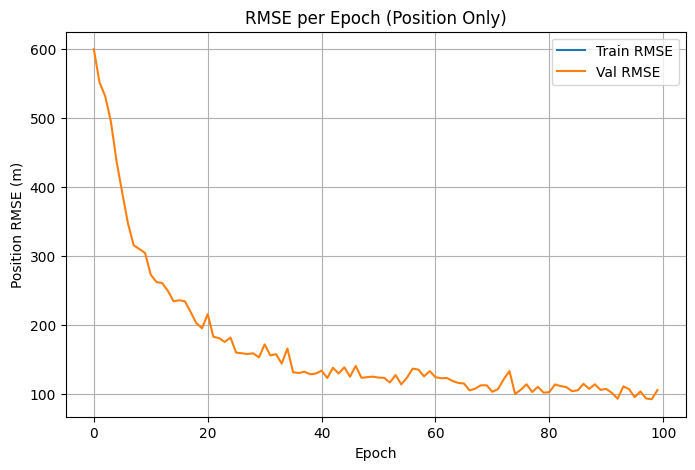

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(rmse_train_pos_epochs, label='Train RMSE')
plt.plot(rmse_val_pos_epochs, label='Val RMSE')
plt.xlabel("Epoch")
plt.ylabel("Position RMSE (m)")
plt.title("RMSE per Epoch (Position Only)")
plt.grid(True)
plt.legend()
plt.show()


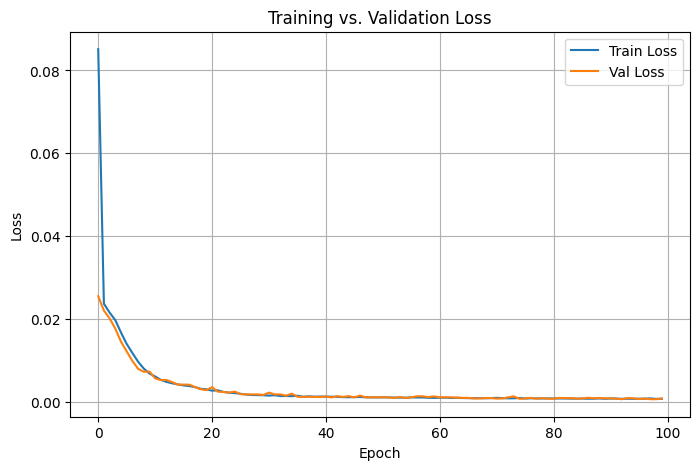

In [15]:
# start from 10th epoch

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# # Load model
# model_ik_o = InverseKinematicMLP(input_size=3, output_size=9)
# model_ik_o.load_state_dict(torch.load("inverse_kinematic_model_9000.pth"))
# model_ik_o.eval()

# # Load actuation sample from saved dataset
# scaler_X_ik = joblib.load("scaler_X_ik_9000.save")
# scaler_Y_ik = joblib.load("scaler_Y_ik_9000.save")

# Test on test set

In [13]:
# Load the saved model
model_ik = InverseKinematicMLP(input_size=9, output_size=9)
model_ik.load_state_dict(torch.load("inverse_kinematic_model_MASS_8999.pth"))
# Evaluate inverse kinematics model
model_ik.eval()
with torch.no_grad():
    Y_pred_ik_test = model_ik(X_ik_test)
    test_loss_ik = loss_fn_ik(Y_pred_ik_test, Y_ik_test).item()
    print("Test Loss (MSE):", test_loss_ik)

Test Loss (MSE): 0.0007846837397664785


In [14]:
Y_pred_ik_test.shape

torch.Size([1800, 9])

In [19]:
Y_pred_test_original = scaler_Y_ik.inverse_transform(Y_pred_ik_test.numpy())
Y_test_original = scaler_Y_ik.inverse_transform(Y_ik_test.numpy())


# Now compute errors in original units:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(Y_test_original, Y_pred_test_original)
mae = mean_absolute_error(Y_test_original, Y_pred_test_original)

# MSE represents the average of the squares of the errors, which is in original units
# MAE represents the average of the absolute differences, which is also in original units
print("Test MSE (original scale):", mse)
print("Test MAE (original scale):", mae)
# RMSE is the square root of MSE, which is also in original units
print("RMSE (original scale):", np.sqrt(mse))

Test MSE (original scale): 12175.3916015625
Test MAE (original scale): 85.8487548828125
RMSE (original scale): 110.34215695536543


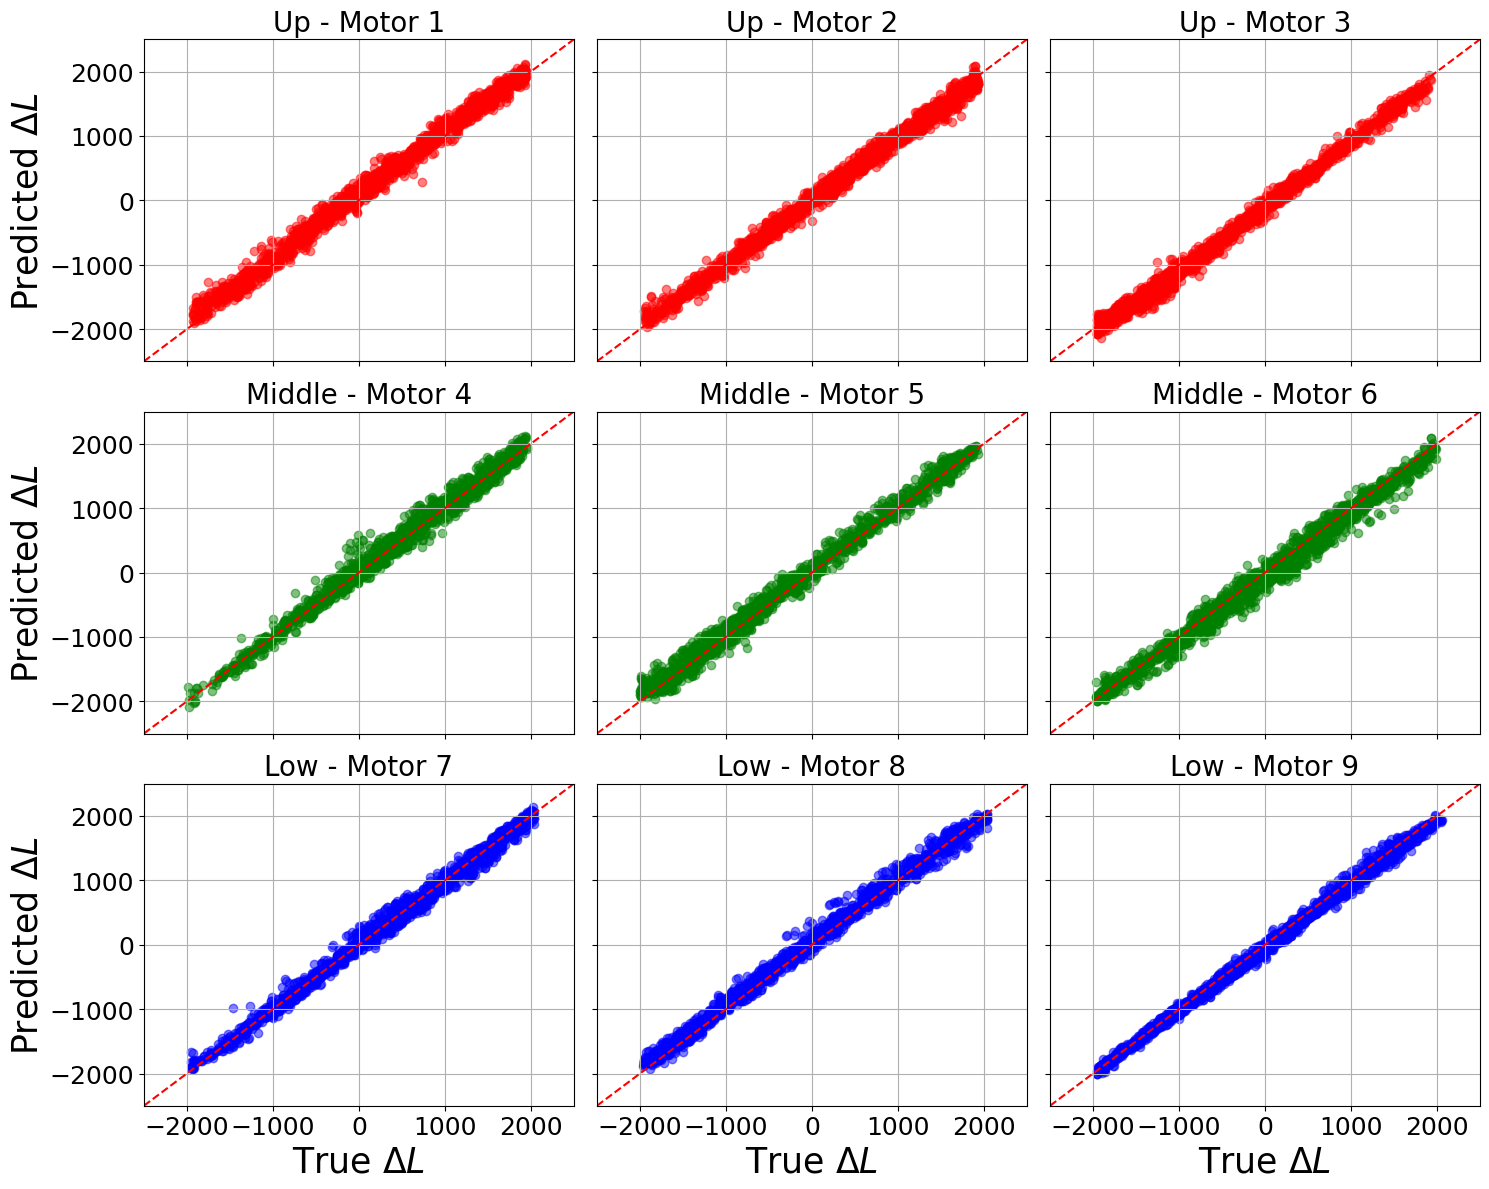

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)

# Re-define section names and colors in the new order: Up, Middle, Low
section_labels = ['Up', 'Middle', 'Low']
section_colors = ['red', 'green', 'blue']

k = 0
for i in range(3):  # Rows: Up, Middle, Low
    section = section_labels[i]
    color = section_colors[i]
    for j in range(3):  # Motors 1–3
        ax = axes[i, j]
        # Calculate the index in original data (Low=0–2, Middle=3–5, Up=6–8)
        if section == 'Low':
            idx = j
        elif section == 'Middle':
            idx = j + 3
        else:  # section == 'up'
            idx = j + 6

        k += 1
        ax.scatter(Y_test_original[:, idx], Y_pred_test_original[:, idx], alpha=0.5, color=color)
        ax.plot([-2500, 2500], [-2500, 2500], 'r--')
        ax.tick_params(axis='both', labelsize=18)
        # Only add x-axis label on the bottom row
        if i == 2:
            ax.set_xlabel("True $\Delta L$", fontsize=25)

        # Only add y-axis label on the first column
        if j == 0:
            ax.set_ylabel("Predicted $\Delta L$", fontsize=25)
        ax.set_title(f"{section.capitalize()} - Motor {k}", fontsize=20)
        # ax.legend(loc='upper left')
        ax.grid(True)
        ax.set_xlim(-2500, 2500)
        ax.set_ylim(-2500, 2500)

plt.tight_layout()
plt.show()


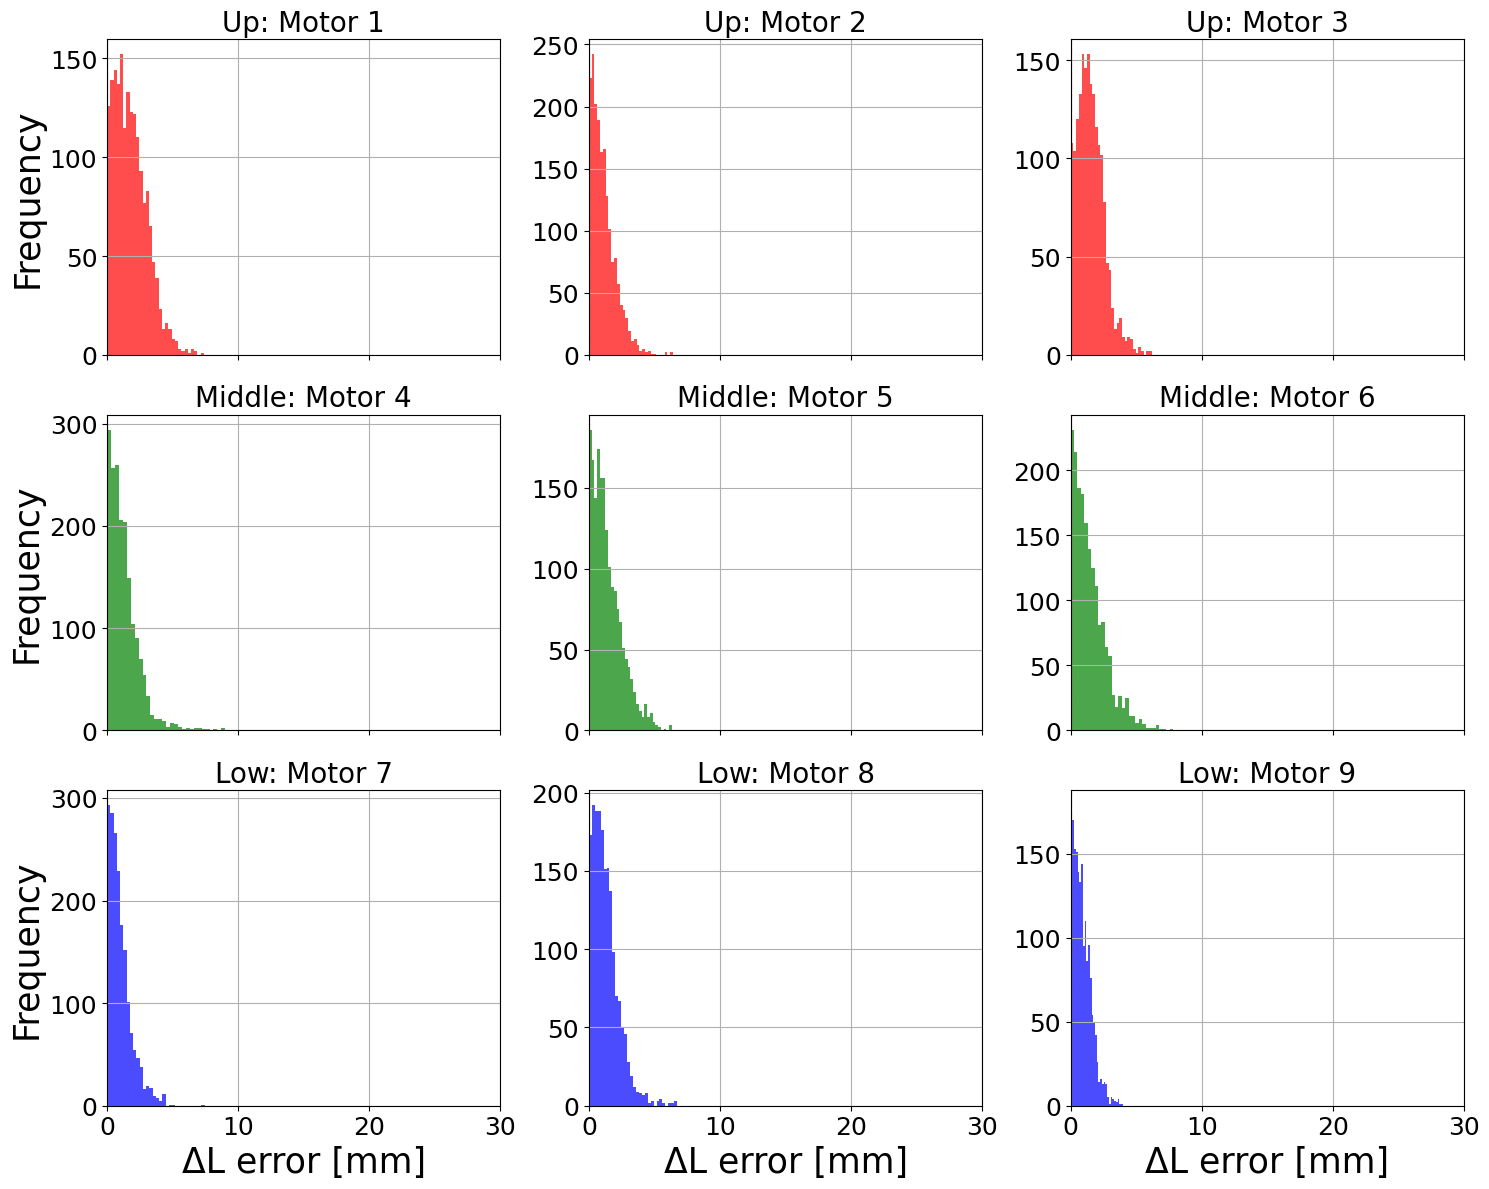

In [21]:
residuals = np.abs(Y_test_original - Y_pred_test_original)

# Convert residuals to delta L values
diff_deltaL = residuals * 0.01534

fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True)

# Define new order: up → middle → low
group_labels = ['Up', 'Middle', 'Low']
group_colors = ['red', 'green', 'blue']

column_indices = [6, 7, 8, 3, 4, 5, 0, 1, 2]

for plot_idx, col_idx in enumerate(column_indices):
    i = plot_idx // 3  # row
    j = plot_idx % 3   # col
    k = plot_idx + 1   # motor number
    ax = axes[i, j]
    
    ax.set_xlim(0, 30)
    # ax.set_ylim(0, 1200)

    ax.hist(diff_deltaL[:, col_idx], bins=30, alpha=0.7, color=group_colors[i])
    
    group = group_labels[i]
    ax.set_title(f"{group}: Motor {k}", fontsize=20)
    # Axis ticks
    ax.tick_params(axis='both', labelsize=18)

    # X-label only on bottom row
    if i == 2:
        ax.set_xlabel("ΔL error [mm]", fontsize=25)

    # Y-label only on first column
    if j == 0:
        ax.set_ylabel("Frequency", fontsize=25)
    ax.axvline(0, color='red', linestyle='--')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [24]:
Y_true_reshaped = Y_test_original.reshape(1800, 3, 3)
Y_pred_reshaped = Y_pred_test_original.reshape(1800, 3, 3)
diff = Y_true_reshaped - Y_pred_reshaped  # shape (1800, 3, 3)
sections = ['low', 'middle', 'up']

print(diff[0])

# for i, sec in enumerate(sections):
#     print(i)
#     sec_diff = diff[:, i, :]  # (1800, 3)
#     sum_sec = np.sum(sec_diff, axis=1)  # (1800,)
#     print(f"Section {sec} sum:", sum_sec[0:5])
#     median_sec = np.median(sec_diff)
#     mean_sec = np.mean(sec_diff)
#     std_sec = np.std(sec_diff)

#     print(f"Section {sec}: Median={median_sec:.6f} ,Mean={mean_sec:.6f}, Std={std_sec:.6f}")

[[   2.4743042  -97.715454   130.41174  ]
 [ -95.530685    -7.9300537  197.98413  ]
 [  17.803467  -104.83362     95.31708  ]]


In [22]:
version = 8999

# Save the inverse kinematics model
torch.save(model_ik.state_dict(), f"inverse_kinematic_model_MASS_{version}.pth")

# Save the scalers for inverse kinematics
joblib.dump(scaler_X_ik, f"scaler_X_ik_MASS_{version}.save")
joblib.dump(scaler_Y_ik, f"scaler_Y_ik_MASS_{version}.save")

print("Inverse kinematics model and scalers saved!")

Inverse kinematics model and scalers saved!
